# Recurrent Neural Network

## 3.1 Hyperparameter Tuning

## Part 0: Introduction

We will be implementing a recurrent neural network in pytorch using the Belgian traffic sign database you have made use of in the previous tutorial. By the end of this tutorial you will be able to compare the performance of an RNN with that of the CNN you have already implemented for the task of classifying images. Evidently image classification is not the strength of an RNN as RNNs are primarily used on time series data. In this tutorial the image data will be simulated into time series data, by inputting each image into the model one column at a time. Hopefully the model will be able to learn the relationship between the image columns to correctly classify them.

## Part 1: Importing packages and Dataset loading

First of all we will be importing the packages that we will be using for our implementation. A number of these should be familiar to you by now

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
from torchvision import datasets as dsets
from torchvision import transforms as trans
torch.manual_seed(0)
import matplotlib.pyplot as plt

import time
import math
import multiprocessing as mp

Now that the packages are imported we can start by loading the data. We will be making use of PyTorch's image dataset importer and the dataset loader as in the previous tutorial. The dataset importer class will create an instance that fetches an image and class and applies a transform to the image. The data loader will then handlle the shuffling of the data and also the drawn batch size.

In [2]:
# Loading dataset
from PIL import Image
import pathlib
import os
from torch.utils.data import Dataset, DataLoader
from glob import glob

class BelgiumTSCDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.paths = glob(os.path.join(self.root, '**', "*.png"))
        self.classes = [name for name in os.listdir(self.root) if os.path.isdir(os.path.join(self.root, name))]

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        
        path = self.paths[idx]
        img = self.transform(Image.open(path))
        label = int(path.split(os.path.sep)[-2])
        return img, label
    
train_Dir = "../Tutorial 3 - Introduction to Neural Networks and CNNs/data/BelgiumTSC_Training/Training"
test_Dir = "../Tutorial 3 - Introduction to Neural Networks and CNNs/data/BelgiumTSC_Testing/Testing"

transforms = trans.Compose([trans.Grayscale(), trans.Resize([28,28]), trans.ToTensor(), 
                            trans.Normalize(mean=(0.5,), std = (0.5,))])

train_data = BelgiumTSCDataset(root=train_Dir, transform= transforms)
test_data = BelgiumTSCDataset(root=test_Dir, transform= transforms)


Lets take a look at what our data looks like using matplotlib by running the following command. Play around with the command below to understand how the data is indexed.One question.

<span style="color:red">**EXERCISE 1:**</span> Why is the .view() method required?

torch.Size([1, 28, 28])
torch.Size([28, 28])


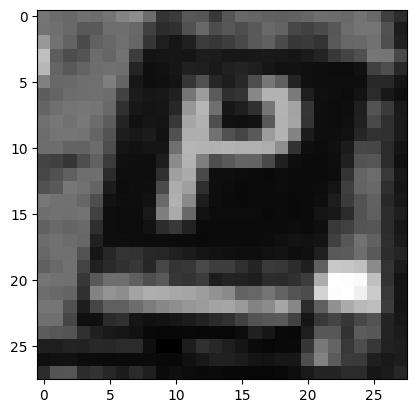

In [3]:
image = train_data[0][0]

print(image.shape)

image = image.view(28,28)


print(image.shape)

plt.imshow(image, cmap='gray')

Now, we want to check how the columns of this image look like. Our network will receive each column at a time. Therefore, we will need to call the model 28 (equals to the number of columns) times for each batch of images in order to get the predicted labels for that batch.

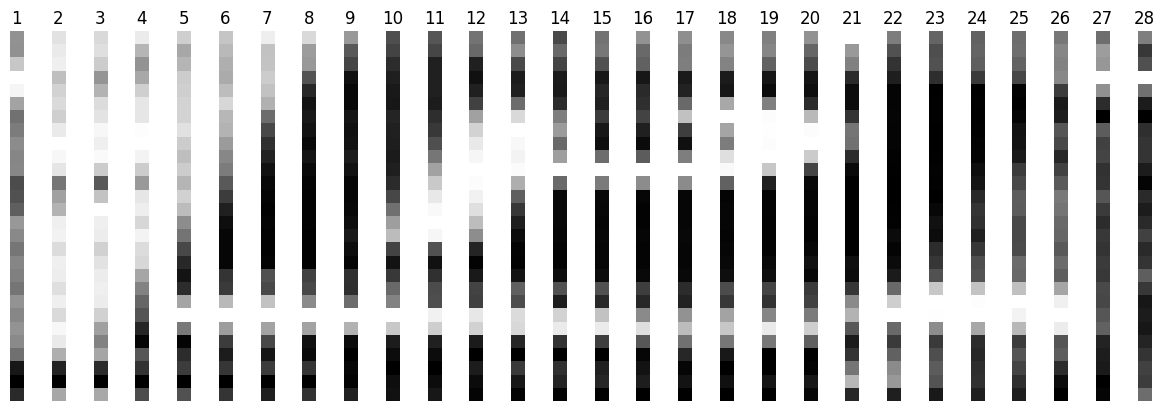

In [4]:
fig, axes = plt.subplots(1, 28)
fig.set_figwidth(15)
for column in range(28):
    axes[column].imshow(image[:,column].view(28,1), cmap='gray')
    axes[column].axis('off')
    axes[column].set_title(str(column + 1))

Now that we have a way to obtain our images and transform them, we now need to pass the training dataset to an image loader to sort into batches and shuffle for training. For the time being we will be training using a batch size of 1.

In [46]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 1, shuffle =True, num_workers=1,drop_last=True)

## Part 2:Implementing the RNN class

It is important to note that we will be inheriting the neural network class from torch.nn. As a child class we will have access to the methods of nn.Module. To define our class we will write the initialisation method to state the types of layers that we will be using. We will also write a forward method to describe how the defined layers are connected. Additionally we will also create a method for initialising a hidden layer to have something to input to the RNN at time = 0.

In [29]:
class RNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(RNN, self).__init__()
            self.hidden_size = hidden_size
            self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
            self.i2o = nn.Linear(input_size + hidden_size, output_size)
            self.softmax = nn.LogSoftmax(dim=1)

        def forward(self, input, hidden):
            combined = torch.cat((input, hidden), 1)
            hidden = self.i2h(combined)
            output = self.i2o(combined)
            output = self.softmax(output)
            return output, hidden

        def initHidden(self):
            return torch.zeros(self.batch_size, self.hidden_size)


![RNN](./Images/RNN.png)

Image and model taken from: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

Note that the input and hidden layer are combined and passed to two fully connected layers. The i2o layer is further fed to a softmax layer that outputs a tensor with a normalised probability distribution consisting of (in this case) 62 probabilities, one for each sign class.

## Part 3: Setting parameters and training

Now we want to train our network. For this we need to define a training function. The training function accepts the following as parameters:

* rnn: An RNN instance

* category_tensor: A category tensor, which is a 1×62 one-hot tensor with a 1 on the labelled category and 0s for all the others

* image_tensor: The image

* criterion: The loss function

* learning_rate: The learning rate

Note that we are not using an optimizer function to automatically subtract the gradients from the weights, instead we subtract the gradient data from each of the parameters directly. This is basically applying the gradient descent method.

The training function will return the output and loss so that we can display some info whilst training and plot the loss.

<span style="color:red">**EXERCISE 2:**</span> Fill the incomplete line in the train function. (follow the comments).

In [30]:
def train(rnn, category_tensor, image_tensor, criterion, learning_rate):
        # 1. Initialise the hidden layer using initHidden function.
        rnn.batch_size = image_tensor.size(0)  # Set the batch size attribute

        hidden = rnn.initHidden()         

        # 2. Set RNN gradients to 0
        rnn.zero_grad()

        # 3. Remove the "image channels" dimension of image_tensor which has size 1 (gray scale image).
        image_tensor = torch.squeeze(image_tensor, 1) 


        # 4. loop through the different columns and apply each to RNN
        # Note: At each step, the hidden state of previous step should also be inputted.
        for i in range(image_tensor.size()[1]):
            output, hidden = rnn(image_tensor[:,i], hidden)

        # 5. Compute the loss given the loss function (criterion)
        loss = criterion(output , category_tensor)    

        # 6. Automatically compute the gradients of network parameters 
        loss.backward()

        # 7. Finally add parameters' gradients to their values, multiplied by learning rate(x(-1)). 
        # This is the SGD method, you could use an optimiser to do this for you
        for p in rnn.parameters():
            p.data.add_(-learning_rate, p.grad.data)

        return output, loss.item()


The following is a small function to calculate the time that has passed since the start of training. The time is returned in mins and seconds

In [31]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

We'll set the hyperparameters for the training and start a timer to see how long training takes. Next we start feeding in data to the model using the data loader. The loss is accumulated every *plot_every* training batches and is logged for plotting. The following code will help you run the training for 1 batch

In [55]:
n_hidden = 128
column_size = 28
n_categories = len(train_data.classes)
rnn = RNN(column_size, n_hidden, n_categories)  # Instantiating from our RNN model

learning_rate = 0.001
criterion = nn.NLLLoss()

n_epochs = 18
print_every = 100
plot_every = 10

current_loss = 0
all_losses = []  
start = time.time()

for ite in range(1, n_epochs + 1):
    # Break training data tuple into image tuple and label tuple
    for batch_idx, (image, label) in enumerate(train_loader):
        output, loss = train(rnn, label, image, criterion, learning_rate)
        current_loss += loss
        # Print iter number, loss, name and guess
        if batch_idx % print_every == 0:
            guess = output[0].topk(1)[1].view([1])
            for i in range(guess.size(0)):  # Loop over elements in the batch
                
                correct = '✓' if guess[i] == label[i] else '✗ Actual Class:%s' % label[i].item()
            
            print('%d %d%% (%s) %.4f / Predicted Class:%s,  %s' %
                  ((ite-1)*4500 + print_every + batch_idx,
                   ((ite-1)*4500 + print_every + batch_idx) / (len(train_loader.dataset)* n_epochs) * 100,
                   timeSince(start), loss, guess.item(), correct))

        # Add current loss avg to list of losses
        if (batch_idx+1) % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0


   

100 0% (0m 0s) 4.1842 / Predicted Class:55,  ✗ Actual Class:61
200 0% (0m 0s) 3.8095 / Predicted Class:27,  ✗ Actual Class:38
300 0% (0m 1s) 4.3120 / Predicted Class:20,  ✗ Actual Class:18
400 0% (0m 2s) 3.8980 / Predicted Class:39,  ✗ Actual Class:54
500 0% (0m 4s) 4.2587 / Predicted Class:27,  ✗ Actual Class:28
600 0% (0m 5s) 4.0906 / Predicted Class:38,  ✗ Actual Class:24
700 0% (0m 6s) 3.9776 / Predicted Class:38,  ✗ Actual Class:47
800 0% (0m 6s) 3.7874 / Predicted Class:27,  ✗ Actual Class:53
900 1% (0m 8s) 3.7882 / Predicted Class:32,  ✗ Actual Class:61
1000 1% (0m 9s) 4.5466 / Predicted Class:14,  ✗ Actual Class:61
1100 1% (0m 10s) 4.1071 / Predicted Class:38,  ✗ Actual Class:41
1200 1% (0m 11s) 3.8129 / Predicted Class:38,  ✗ Actual Class:40
1300 1% (0m 12s) 4.1438 / Predicted Class:32,  ✗ Actual Class:37
1400 1% (0m 13s) 3.8754 / Predicted Class:22,  ✓
1500 1% (0m 14s) 3.6024 / Predicted Class:32,  ✗ Actual Class:38
1600 1% (0m 15s) 4.6211 / Predicted Class:22,  ✗ Actual Clas

Now that the network has been trained we can have a look at the loss. Run the following code.

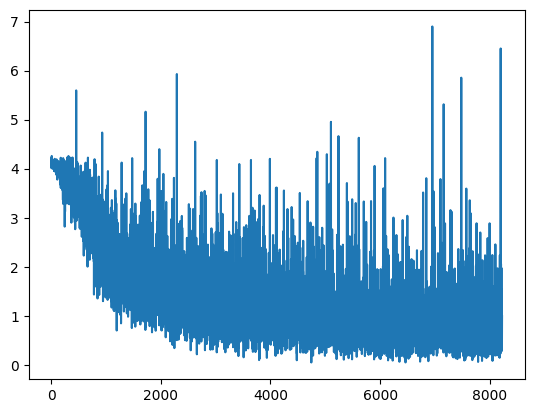

In [56]:
plt.figure()
plt.plot(all_losses)

<span style="color:red">**EXERCISE 3:**</span> As can be seen above, the loss is slowly decreasing the more we train. The loss is very noisy though. Do you know why this could be?

In [ ]:
#since the batch size in 1 the gradient is very noisy .to improve change the batch size.

## Part 4: Evaluation

Now it is time to evaluate our model. To do so we're going to create an evaluation function that takes the RNN instance and the test image and tries to predict the correct class. We will then plot a confusion matrix to visually demonstrate the RNN's predictions. Write an evaluation function below to apply the image column by column to the RNN. The input parameters are the RNN instance and the image. The class prediction tensor should be returned. 

<span style="color:red">**EXERCISE 4:**</span> Complete the following function.

In [53]:
def evaluate(rnn, image):
    # 1. Initialise hidden state
    
    hidden =   rnn.initHidden()  
    # 2. Remove the "image channels" dimension of image_tensor which has size 1 (gray scale image). 
    image_tensor_eval =  torch.squeeze(image,1)  
    
    print(image_tensor_eval.size)
    
    # 3. Loop through the image columns and input them one by one into the RNN (also apply the hidden state of previous step).
    for i in range (image_tensor_eval.size()[1]):
        output, hidden = rnn(image_tensor_eval[: ,i],hidden)
        
    return output

The code below passes the data from test_data into the evaluate function and displays the data as prediction accuracy and a confusion matrix.

<built-in method size of Tensor object at 0x799562977a40>
<built-in method size of Tensor object at 0x799562977a40>
<built-in method size of Tensor object at 0x79956286f9a0>
<built-in method size of Tensor object at 0x7995628e1db0>
<built-in method size of Tensor object at 0x799562977a40>
<built-in method size of Tensor object at 0x79956286f860>
<built-in method size of Tensor object at 0x799562ae64f0>
<built-in method size of Tensor object at 0x79956285db30>
<built-in method size of Tensor object at 0x79956284fae0>
<built-in method size of Tensor object at 0x79956286f9a0>
<built-in method size of Tensor object at 0x799562977a40>
<built-in method size of Tensor object at 0x7995628685e0>
<built-in method size of Tensor object at 0x79956284fae0>
<built-in method size of Tensor object at 0x79956286f8b0>
<built-in method size of Tensor object at 0x799562ae64f0>
<built-in method size of Tensor object at 0x799562977220>
<built-in method size of Tensor object at 0x79956284fae0>
<built-in meth

/tmp/ipykernel_1325843/1379472839.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + test_data.classes, rotation=90)
/tmp/ipykernel_1325843/1379472839.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + test_data.classes)


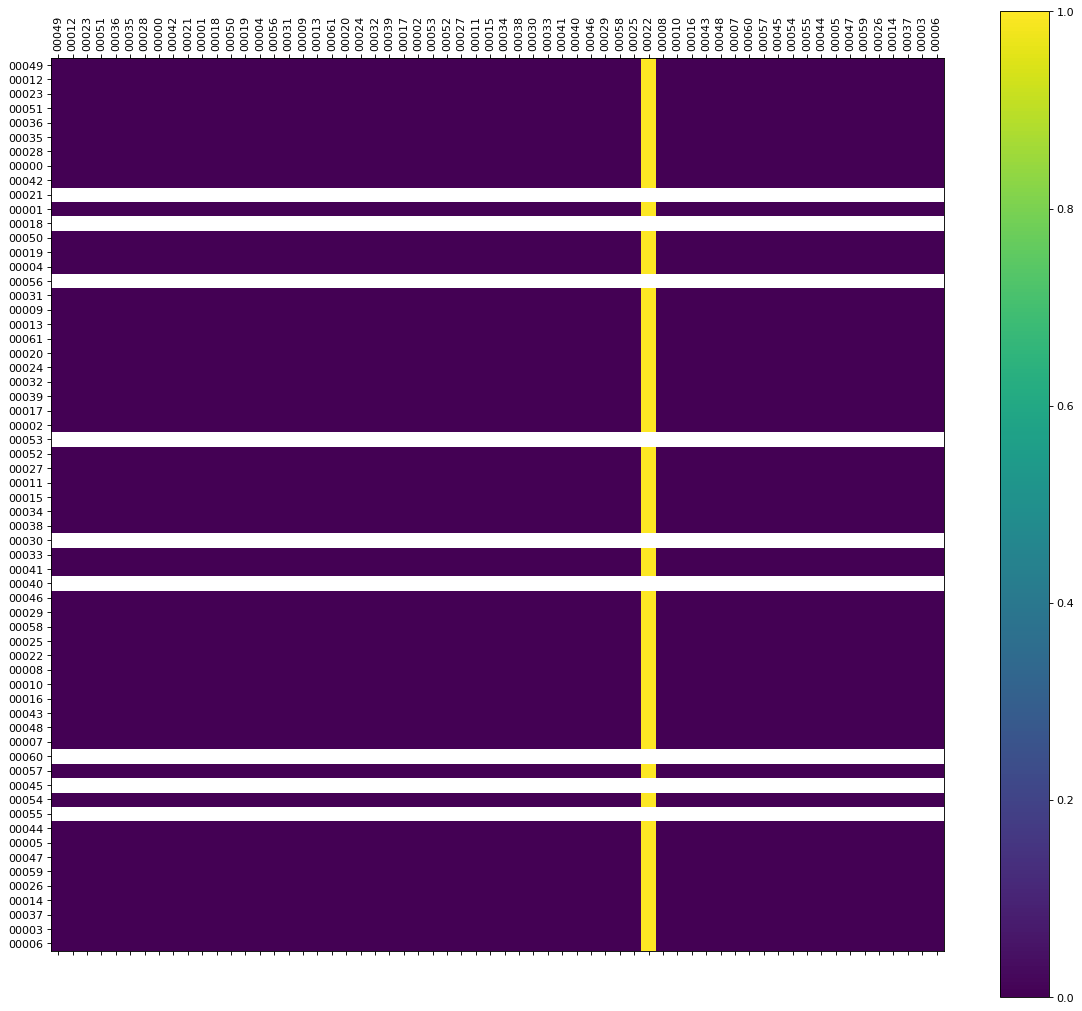

0.44% prediction accuracy


In [54]:
confusion = torch.zeros(n_categories, n_categories)
prediction = []
truth = []
for data in test_data:
    image, label = data
    pred = evaluate(rnn, image)
    prediction.append(pred.topk(1)[1].item())
    truth.append(label)
    confusion[label][pred.topk(1)[1].item()] += 1
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Set up plot
fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + test_data.classes, rotation=90)
ax.set_yticklabels([''] + test_data.classes)
    
# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()
    
# Compute the % of correct guesses
print('%.2f%% prediction accuracy' %(sum(a == b for a,b in zip(truth, prediction))/len(truth)*100))

<span style="color:red">**EXERCISE 5:**</span> With only 1 epoch we can see that the network is not that very good at classifying the test data. Can you explain the following?

1) What is the above figure showing?

2) What is the model classifying the images as? and why is this so?

3) Why is there a number of blank rows in the image?

In [85]:
#The figure show the confusion matrix 
#The model is classifying images to a particular class . each class represents a image content .
#Since it is not ordered the input class does not match with the output class as there are no predictions for he particular class  . one And the dataset may not be diverse . 

## 3.2 Time Series Data Analysis

In [12]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
#Loading Unprocessed dataset
data = pd.read_csv("Question3_dataset/pma3_raw_data_a.csv")
data['DateTime']= pd.to_datetime(data['DateTime'])
data.head()

,DateTime,Vehicles
0,2015-01-11 00:00:00,15.0
1,2015-01-11 01:00:00,13.0
2,2015-01-11 02:00:00,10.0
3,2015-01-11 03:00:00,7.0
4,2015-01-11 04:00:00,9.0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  14592 non-null  datetime64[ns]
 1   Vehicles  14592 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 752.0 KB


In [15]:
data1 = np.load('Question3_dataset/pma3_x_train.npy')
print(data1.shape)
print(data[:10])


(11534, 5, 1)
             DateTime  Vehicles
0 2015-01-11 00:00:00      15.0
1 2015-01-11 01:00:00      13.0
2 2015-01-11 02:00:00      10.0
3 2015-01-11 03:00:00       7.0
4 2015-01-11 04:00:00       9.0
5 2015-01-11 05:00:00       6.0
6 2015-01-11 06:00:00       9.0
7 2015-01-11 07:00:00       8.0
8 2015-01-11 08:00:00      11.0
9 2015-01-11 09:00:00      12.0


## 3.2.a

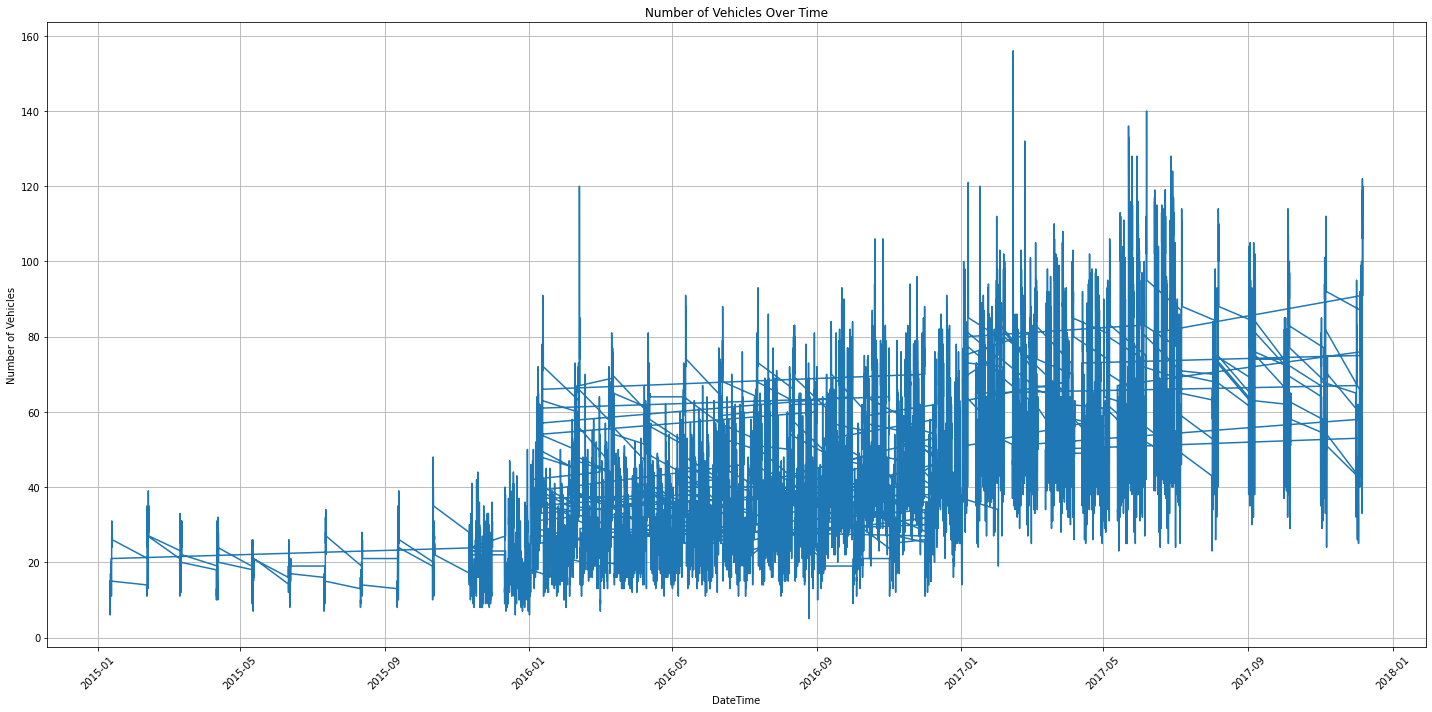

In [25]:


# Extract the datetime and number of vehicles columns
datetime = data["DateTime"]
vehicles = data["Vehicles"]

# Configure the plot
plt.figure(figsize=(20, 10))
plt.plot(datetime, vehicles)

# Label the axes
plt.xlabel("DateTime")
plt.ylabel("Number of Vehicles")

# Add a title
plt.title("Number of Vehicles Over Time")

# Show the plot
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability with many entries
plt.tight_layout()
plt.show()

## 3.2 b Decompose the time Series

In [26]:

# Extract components
data['Year'] = data['DateTime'].dt.year
data['Month'] = data['DateTime'].dt.month
data['Day'] = data['DateTime'].dt.day
data['Hour'] = data['DateTime'].dt.hour


In [27]:
# Group by the components and calculate the average
data_avg = data.groupby(['Year', 'Month', 'Day', 'Hour'])['Vehicles'].mean()

# Convert the MultiIndex into columns for easier handling
data_avg = data_avg.reset_index() 




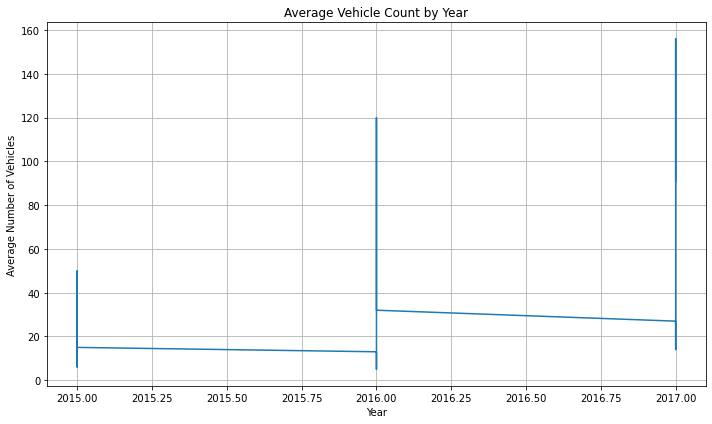

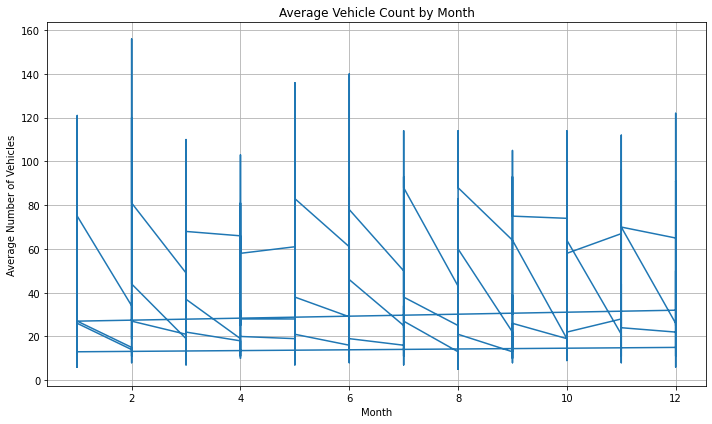

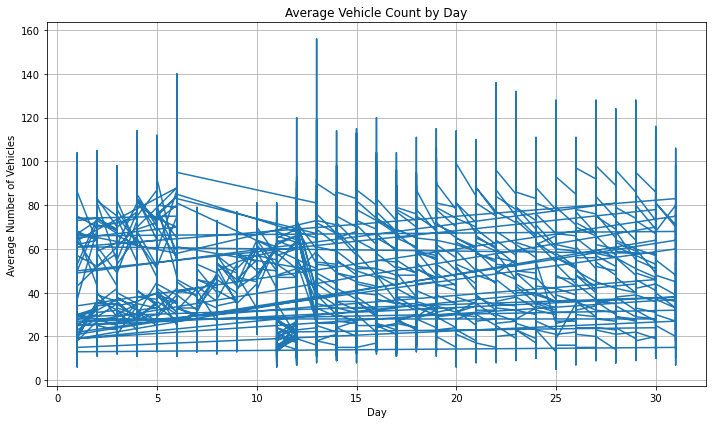

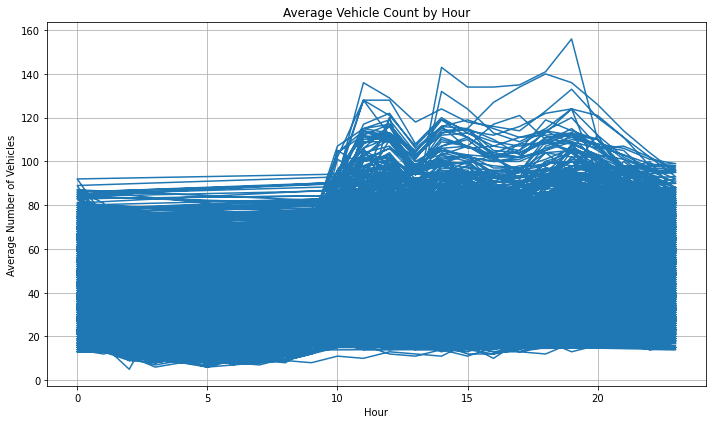

In [28]:
time_components = ['Year', 'Month', 'Day', 'Hour']

for component in time_components:
    plt.figure(figsize=(10, 6))
    plt.plot(data_avg[component], data_avg['Vehicles'])
    plt.xlabel(component)
    plt.ylabel('Average Number of Vehicles')
    plt.title(f'Average Vehicle Count by {component}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 3.3 Implementing RNN model for different tasks

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [ ]:
##Load Dataset

In [9]:


def load_npy_dataset(pma3_x_train, pma3_y_train, pma3_x_test, pma3_y_test):
    """Loads preprocessed NumPy arrays (.npy files) for traffic flow forecasting. """

    x_train = np.load("../Question3_dataset_a/pma3_x_train.npy")
    y_train = np.load("../Question3_dataset_a/pma3_y_train.npy")
    x_test = np.load("../Question3_dataset_a/pma3_x_test.npy")
    y_test = np.load("../Question3_dataset_a/pma3_y_test.npy")
    x_train = x_train.astype(np.float32)
    y_train = y_train.astype(np.float32)
    x_test = x_test.astype(np.float32)


    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = load_npy_dataset("pma3_x_train", "pma3_y_train", "pma3_x_test", "pma3_y_test")


In [10]:
batch_size = 32 
learning_rate = 0.001
itr = 4 

# Create TensorDataset and DataLoader
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) 

In [18]:
try:
    device = torch.device('cpu')
except RuntimeError:
    print("MPS not available, defaulting to CPU")
    device = torch.device('cpu')

In [ ]:
##Model Class

In [12]:
class Model(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)  # Output of last GRU layer
        out = out[:, -1, :]  # Take the last timestep's output
        out = self.linear(out) 
        return out 


In [ ]:
##Train Model Function

In [21]:
def train_model():
    print('Model training') 
    

    # Create TensorDataset and DataLoader
    train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)  # Add shuffle=True

    # Model, loss, optimizer setup 
    model = Model().to(device)
    criterion = nn.MSELoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.001)  

    # Training loop
    num_epochs = 5
    tolerance = 5.0  # Tolerance for considering a prediction accurate

     
    for epoch in range(num_epochs):
        num_correct = 0  # Count of accurate predictions within a batch
        total_samples = 0
        for x_batch, y_batch in train_loader: 
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()   

            y_pred = model(x_batch) 
            # Expand dimensions of y_batch to match the shape of y_pred
            y_batch = y_batch.unsqueeze(1)  # Add dimension at index 1
            loss = criterion(y_pred, y_batch)
            loss.backward()         
            optimizer.step()   
            # Accuracy calculation
            predictions = y_pred.squeeze().detach().cpu().numpy() 
            ground_truth = y_batch.detach().cpu().numpy()
            total_samples += y_batch.size(0)
            num_correct += (abs(predictions - ground_truth) <= tolerance).sum()

        batch_accuracy = num_correct / total_samples * 100
        # Print progress 
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


    return model 


In [ ]:
##Test Model Function

In [22]:
def test_model(model, x_test, y_test):
    """Evaluates the performance of a trained model and visualizes the predicted and actual output.

    Input Parameters:
        model (torch.nn.Module): The model to test. Must be a PyTorch model.
        x_test (numpy.ndarray): The input data for testing. Must be a 3D numpy array where each 
                                slice along the second axis is an input sample.
        y_test (numpy.ndarray): The true output data for testing. Must be a 1D numpy array where 
                                each element is the true output for the corresponding input sample in x_test.

    Returns:
        None. Prints the root mean squared error of the model's predictions and displays a plot 
              of the model's predictions and the true values.
    """

    print('Model evaluation')

    # Convert data to tensors and move to the device
    x_test = x_test.astype(np.float32) 
    x_test = torch.from_numpy(x_test).to(device).to(torch.float32)

    # Put model in evaluation mode
    model.eval()

    with torch.no_grad():  # Disable gradient calculation for evaluation
        y_pred = model(x_test.float())  
        y_pred = y_pred.cpu().numpy()  # Move predictions to CPU for easier manipulation

        if np.any(np.isnan(y_pred)):
            print("Model failed training, try different hyperparameters or model architecture")
        else:
            rmse = math.sqrt(mean_squared_error(y_test, y_pred))
            print('-'* 15)
            print(f'Model root mean squared error is {rmse}')
            print('-'* 15)

            # Visualization
            plt.figure(figsize=(12,5))
            plt.plot(y_test, color='black', label='True Value', alpha=0.5)
            plt.plot(y_pred, color='red', label='Predicted Values')
            plt.title('Traffic Forecasting')
            plt.xlabel('Timestep')
            plt.ylabel('Number of Vehicles (Normalised)')
            plt.legend()
            plt.show()



Model training
Epoch 1/5, Loss: 0.0015
Model evaluation
---------------
Model root mean squared error is 0.035614226686937554
---------------


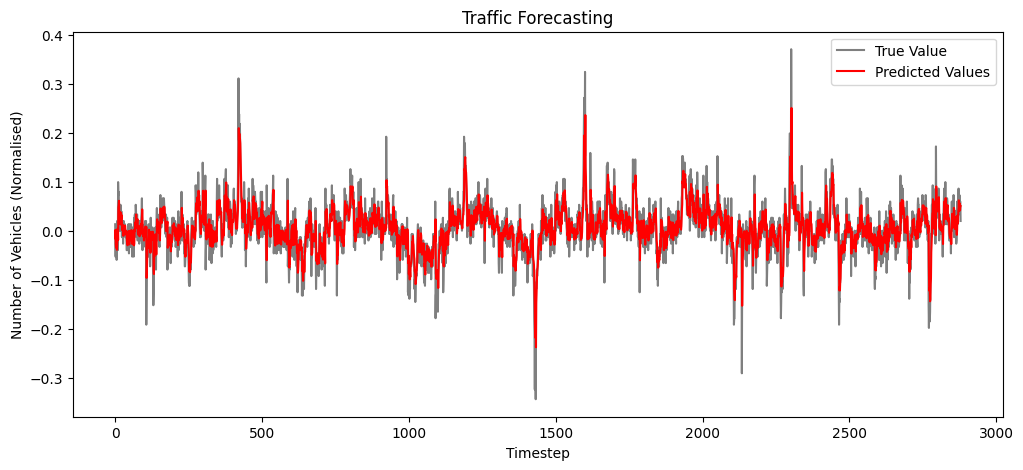

In [23]:
if __name__ == "__main__":
    # Train the model
    trained_model = train_model()
    test_model(trained_model, x_test, y_test)